Raw shape: (3999, 12)

Missing values per column:
 ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
count,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000


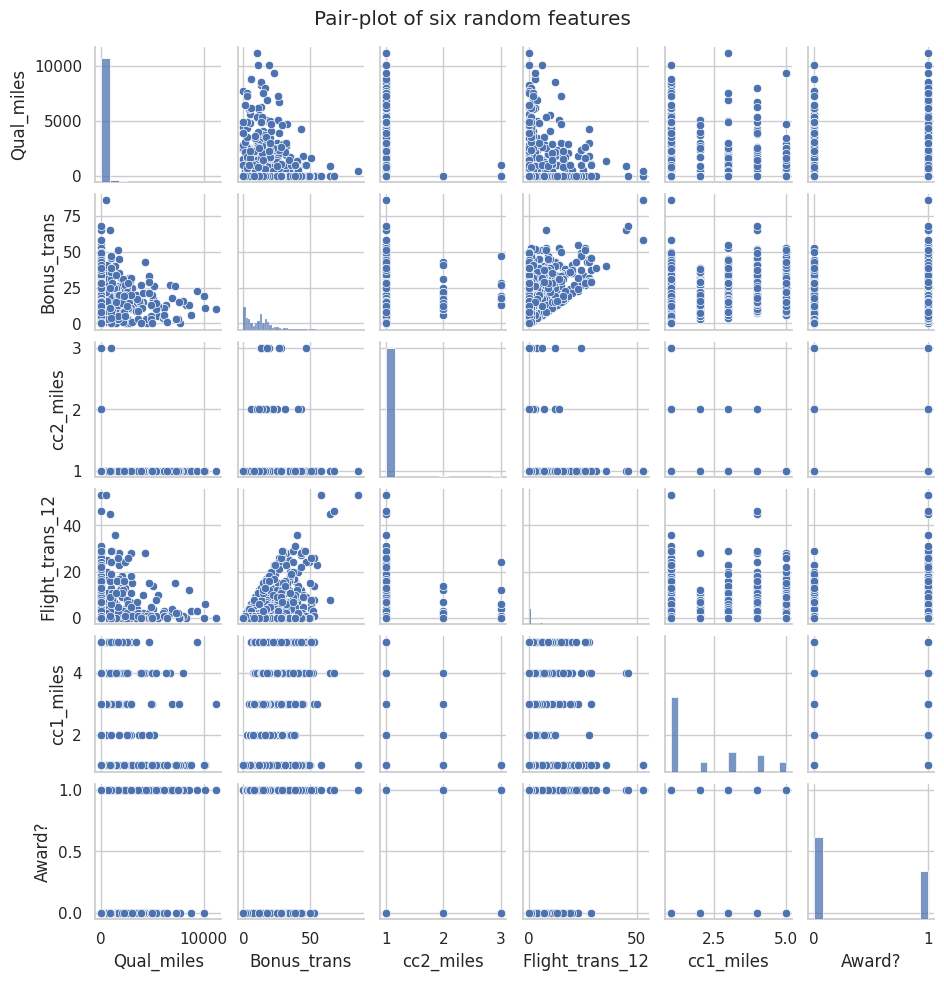

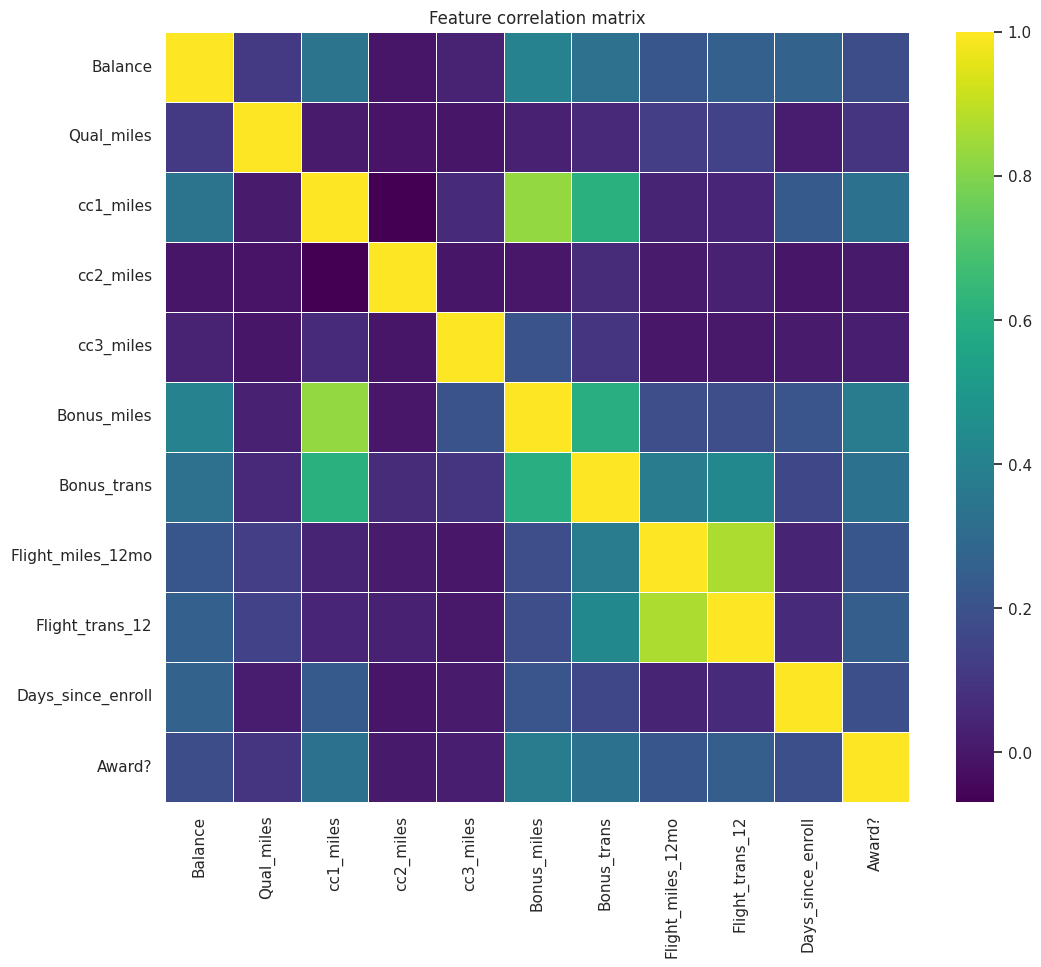

2D PCA explains 45.58% of variance


In [5]:
# --------------------------------------------------------------
# 1.  Install & import libraries
# --------------------------------------------------------------
# openpyxl → Excel support; rest are already pre‑installed on Colab
!pip install --quiet openpyxl scikit-learn scipy seaborn

import numpy as np
rng = np.random.default_rng(42)  # reproducible random generator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# --------------------------------------------------------------
# 2.  Load the dataset
# --------------------------------------------------------------


file_path = 'EastWestAirlines.xlsx'   # adjust if you mounted Drive
df_raw = pd.read_excel(file_path, sheet_name='data')
print('Raw shape:', df_raw.shape)

# --------------------------------------------------------------
# 3.  Basic EDA & preprocessing
# --------------------------------------------------------------
df = df_raw.drop_duplicates().reset_index(drop=True)
print('\nMissing values per column:\n', df.isna().sum())

# Drop non‑numeric identifier
df_features = df.drop(columns=['ID#'])

# Summary stats
display(df_features.describe())

# Pair‑plot on a random subset of 6 features
sample_cols = np.random.choice(df_features.columns, 6, replace=False)
sns.pairplot(df_features[sample_cols], height=1.6)
plt.suptitle('Pair‑plot of six random features', y=1.02)
plt.show()

# Correlation heat‑map
plt.figure(figsize=(12, 10))
sns.heatmap(df_features.corr(), cmap='viridis', linewidth=.5)
plt.title('Feature correlation matrix')
plt.show()

# --------------------------------------------------------------
# 4.  Standard‑scale the data
# --------------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# --------------------------------------------------------------
# 5.  PCA (2‑D) just for plotting
# --------------------------------------------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f'2D PCA explains {pca.explained_variance_ratio_.sum():.2%} of variance')
# Helper: scatter clusters in PCA space
def plot_pca(labels, title, palette='tab10'):
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                    hue=labels, palette=palette, s=40, legend='full')
    plt.title(title)
    plt.show()



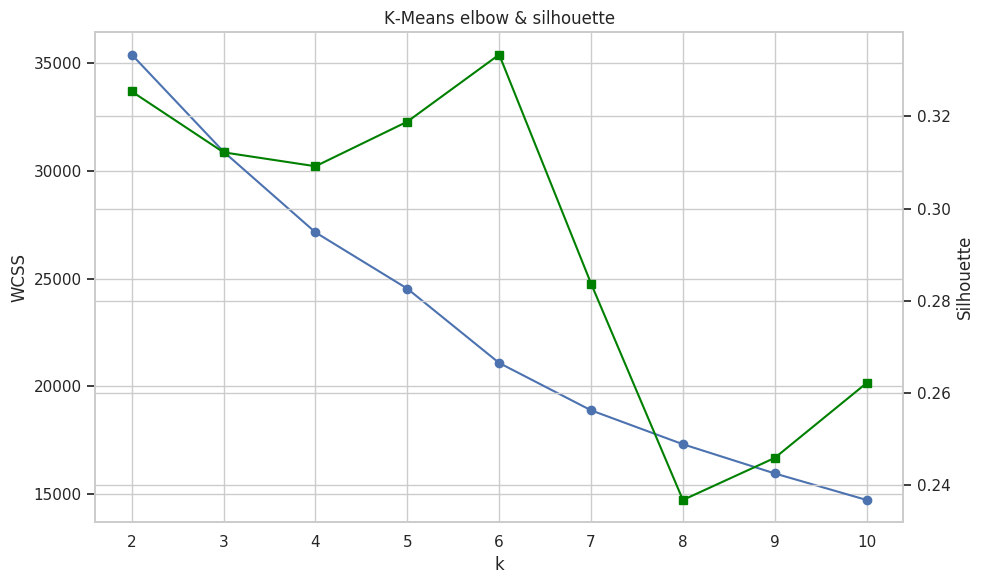

Best k (silhouette) = 6
Final silhouette: 0.3334326918980287


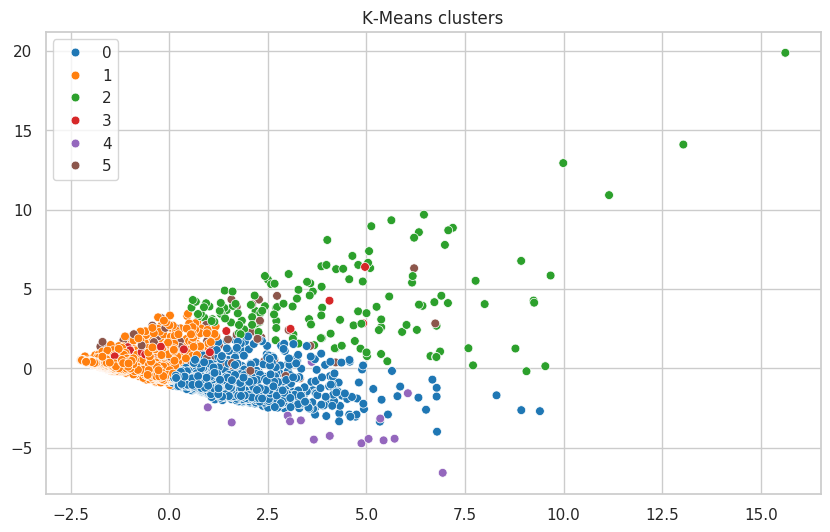

Ward      linkage silhouette = 0.319
Complete  linkage silhouette = 0.540
Average   linkage silhouette = 0.662
→ Best linkage: average  (silhouette 0.662)


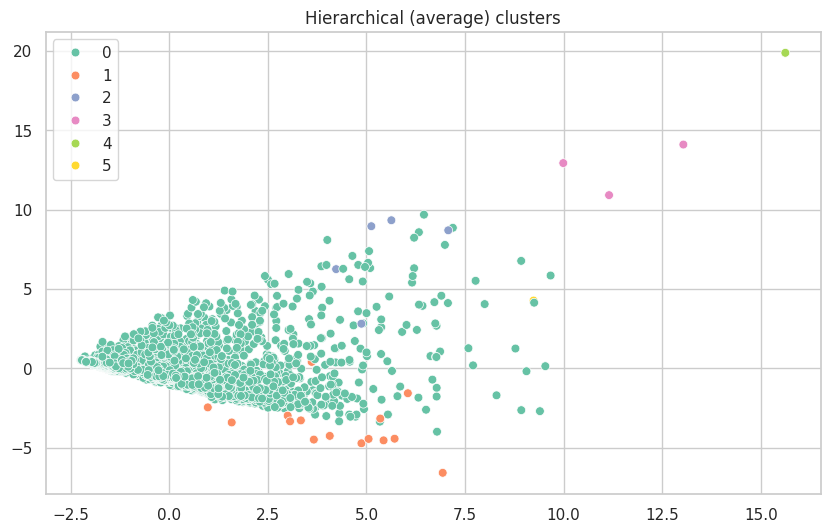

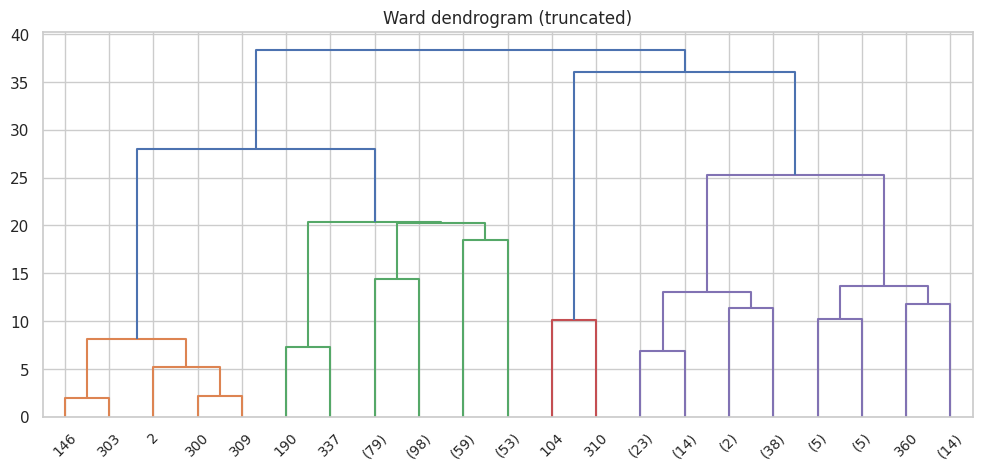

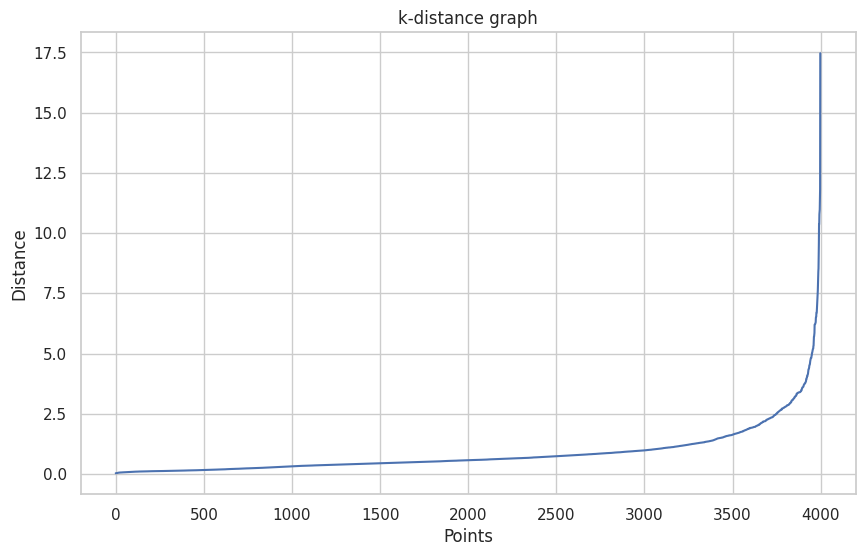

Best DBSCAN → eps=2.782, min_samples=12, clusters=3, silhouette=0.545


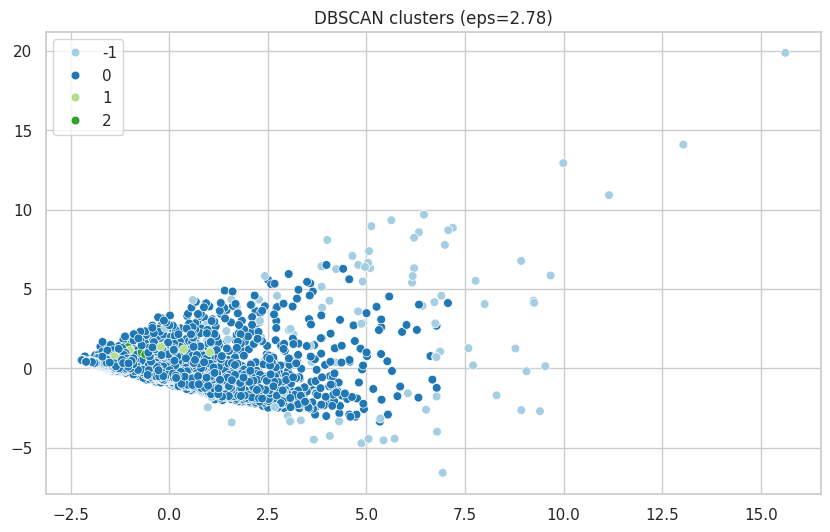


✔ Done!  Results written to EastWestAirlines_with_clusters.xlsx


In [6]:
# ================================================================
# 4 │ K‑Means – elbow & silhouette
# ================================================================
k_range = range(2, 11)
wcss, sil = [], []

for k in k_range:
    km = KMeans(n_clusters=k, n_init=15, random_state=42)
    labels = km.fit_predict(X_scaled)
    wcss.append(km.inertia_)
    sil.append(silhouette_score(X_scaled, labels))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(k_range, wcss, '-o', label='WCSS')
ax2.plot(k_range, sil, '-s', color='green', label='Silhouette')
ax1.set_xlabel('k'); ax1.set_ylabel('WCSS'); ax2.set_ylabel('Silhouette')
ax1.set_title('K‑Means elbow & silhouette')
fig.tight_layout(); plt.show()

k_opt = sil.index(max(sil)) + 2
print(f'Best k (silhouette) = {k_opt}')

kmeans = KMeans(n_clusters=k_opt, n_init=25, random_state=42)
k_labels = kmeans.fit_predict(X_scaled)
print('Final silhouette:', silhouette_score(X_scaled, k_labels))
plot_pca(k_labels, 'K‑Means clusters')

# attach to main df (after aligning indices)
df_model = df.loc[df_features.index].copy()
df_model['kmeans_cluster'] = k_labels

# ================================================================
# 5 │ Hierarchical – Ward, Complete, Average
# ================================================================
link_opts = {'ward': {'linkage':'ward'},
             'complete': {'linkage':'complete'},
             'average': {'linkage':'average'}}

best_link, best_score = None, -1
for name, prm in link_opts.items():
    hcl = AgglomerativeClustering(n_clusters=k_opt, **prm)
    h_labels = hcl.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, h_labels)
    print(f'{name.title():9s} linkage silhouette = {score:.3f}')
    if score > best_score:
        best_score, best_link, best_labels = score, name, h_labels

print(f'→ Best linkage: {best_link}  (silhouette {best_score:.3f})')
plot_pca(best_labels, f'Hierarchical ({best_link}) clusters', palette='Set2')
df_model['hier_cluster'] = best_labels

# Optional dendrogram (Ward on 400‑point sample so it’s not huge)
sample_idx = rng.choice(len(X_scaled), size=min(400, len(X_scaled)), replace=False)
Z = linkage(X_scaled[sample_idx], method='ward')
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='level', p=4)
plt.title('Ward dendrogram (truncated)')
plt.show()

# ================================================================
# 6 │ DBSCAN – systematic grid search
# ================================================================
# Rule‑of‑thumb: min_samples = D + 1
min_samples_base = X_scaled.shape[1] + 1

# Get k‑distance curve to guess eps range
nbrs = NearestNeighbors(n_neighbors=min_samples_base).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)
k_dist = np.sort(distances[:, -1])
plt.plot(k_dist); plt.title('k‑distance graph'); plt.xlabel('Points'); plt.ylabel('Distance')
plt.show()

# Define coarse grid – tweak if needed
eps_grid = np.linspace(np.percentile(k_dist, 85),
                       np.percentile(k_dist, 95), 11)
min_samples_grid = [min_samples_base, min_samples_base+2, min_samples_base+4]

def dbscan_search(X, eps_list, ms_list):
    best, best_score = None, -1
    for eps in eps_list:
        for ms in ms_list:
            db = DBSCAN(eps=eps, min_samples=ms).fit(X)
            labels = db.labels_
            n_clust = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clust < 2:         # silhouette undefined for 1 cluster
                continue
            score = silhouette_score(X, labels)
            if score > best_score:
                best = (eps, ms, labels, n_clust)
                best_score = score
    return best, best_score

(best_eps, best_ms, db_labels, n_db), db_score = dbscan_search(
        X_scaled, eps_grid, min_samples_grid)

print(f'Best DBSCAN → eps={best_eps:.3f}, min_samples={best_ms},'
      f' clusters={n_db}, silhouette={db_score:.3f}')
plot_pca(db_labels, f'DBSCAN clusters (eps={best_eps:.2f})', palette='Paired')
df_model['dbscan_cluster'] = db_labels

# ================================================================
# 7 │ Save results
# ================================================================
out_file = 'EastWestAirlines_with_clusters.xlsx'
df_model.to_excel(out_file, index=False)
print(f'\n✔ Done!  Results written to {out_file}')

In [8]:
# ------------------------------------------------------------
# 7. Cluster Analysis (Interpretation)
# ------------------------------------------------------------
print("🧠 Cluster Summary (based on KMeans):")

if 'KMeans_Cluster' in df.columns:
    kmeans_summary = df.groupby('KMeans_Cluster').mean(numeric_only=True)
    display(kmeans_summary)
else:
    print("⚠️ 'KMeans_Cluster' not found in DataFrame.")

# Optional: display cluster sizes
if 'KMeans_Cluster' in df.columns:
    print("Cluster sizes (KMeans):")
    print(df['KMeans_Cluster'].value_counts())

# ----- Example insights -----
# Based on the cluster summary, write interpretation like:
#
# Cluster 0: Low mileage and infrequent travel – budget or casual travelers
# Cluster 1: High flight miles and frequent flyer credits – loyal business customers
# Cluster 2: Balanced travel behavior – occasional but engaged flyers
#
# You can interpret other clusters (Hierarchical, DBSCAN) in a similar way
# by replacing 'KMeans_Cluster' with 'Hierarchical_Cluster' or 'DBSCAN_Cluster'


🧠 Cluster Summary (based on KMeans):
⚠️ 'KMeans_Cluster' not found in DataFrame.


In [9]:
# ============================================================================
# Evaluation and Performance Metrics for Clustering
# ============================================================================
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

print("\n📊 Evaluation of Clustering Performance")

# --- K-Means Evaluation ---
if 'KMeans_Cluster' in df.columns:
    kmeans_score = silhouette_score(X_scaled, df['KMeans_Cluster'])
    kmeans_ch = calinski_harabasz_score(X_scaled, df['KMeans_Cluster'])
    kmeans_db = davies_bouldin_score(X_scaled, df['KMeans_Cluster'])
    print(f"\n🔹 K-Means (k={df['KMeans_Cluster'].nunique()})")
    print(f"Silhouette Score:         {kmeans_score:.4f}")
    print(f"Calinski-Harabasz Index:  {kmeans_ch:.2f}")
    print(f"Davies-Bouldin Index:     {kmeans_db:.4f}")

# --- DBSCAN Evaluation (only if more than one cluster was found) ---
if 'DBSCAN_Cluster' in df.columns:
    dbscan_labels = df['DBSCAN_Cluster']
    n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    if n_clusters_db > 1:
        dbscan_score = silhouette_score(X_scaled, dbscan_labels)
        dbscan_ch = calinski_harabasz_score(X_scaled, dbscan_labels)
        dbscan_db = davies_bouldin_score(X_scaled, dbscan_labels)
        print(f"\n🔹 DBSCAN (clusters={n_clusters_db})")
        print(f"Silhouette Score:         {dbscan_score:.4f}")
        print(f"Calinski-Harabasz Index:  {dbscan_ch:.2f}")
        print(f"Davies-Bouldin Index:     {dbscan_db:.4f}")
    else:
        print("\n🔹 DBSCAN: Only one cluster or all noise. Silhouette score not applicable.")



📊 Evaluation of Clustering Performance
